In [1]:
import os
import ast
import wfdb
import numpy as np
import pandas as pd

os.chdir("../..")
import utils

In [2]:
outputfolder = os.getcwd() + '/output/'
datafolder = os.getcwd() + '/datasets/PTB-XL/'
sampling_rate = 100
task = 'priority'
experiment_name = 'exp4'

In [3]:
data, raw_labels = utils.load_dataset(datafolder, sampling_rate=sampling_rate)
labels = utils.compute_label_aggregations(raw_labels, datafolder, task)
data, labels, Y, _ = utils.select_data(data, labels, task, 0, outputfolder+experiment_name+'/data/')

In [4]:
X_test = data[labels.strat_fold == 10]
y_test = Y[labels.strat_fold == 10]

X_val = data[labels.strat_fold == 9]
y_val = Y[labels.strat_fold == 9]

X_train = data[labels.strat_fold <= 8]
y_train = Y[labels.strat_fold <= 8]

n_classes = y_train.shape[1]

print(f"This experiment has {n_classes} classes")

X_train = X_train[:,:,0]
X_test = X_test[:,:,0]
X_val = X_val[:,:,0]

This experiment has 43 classes


In [5]:
import tensorflow as tf

In [11]:
inputs = tf.keras.Input(shape=(1000,1))

x = tf.keras.layers.Conv1D(64, 5, activation='relu', padding='same')(inputs)
x = tf.keras.layers.MaxPool1D(pool_size=2)(x)
x = tf.keras.layers.Conv1D(128, 3, activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPool1D(pool_size=2)(x)

attention = tf.keras.layers.MultiHeadAttention(num_heads=4, key_dim=2)(x, x)
x = tf.keras.layers.Concatenate()([x, attention])
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(x)

branch1 = tf.keras.layers.Conv1D(64, 3, activation='relu', padding='same')(x)
branch1 = tf.keras.layers.MaxPooling1D(2)(branch1)
branch1 = tf.keras.layers.Flatten()(branch1)

branch2 = tf.keras.layers.Conv1D(64, 5, activation='relu', padding='same')(x)
branch2 = tf.keras.layers.MaxPooling1D(2)(branch2)
branch2 = tf.keras.layers.Flatten()(branch2)

x = tf.keras.layers.Concatenate()([branch1, branch2])
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(43, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [12]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), 
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                  metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy', threshold=0.5),
                           tf.keras.metrics.Recall(name='Recall'),
                           tf.keras.metrics.Precision(name='Precision'),
                           tf.keras.metrics.AUC(num_thresholds=200, curve="ROC", name="AUC",
                                                multi_label=True, label_weights=None)])

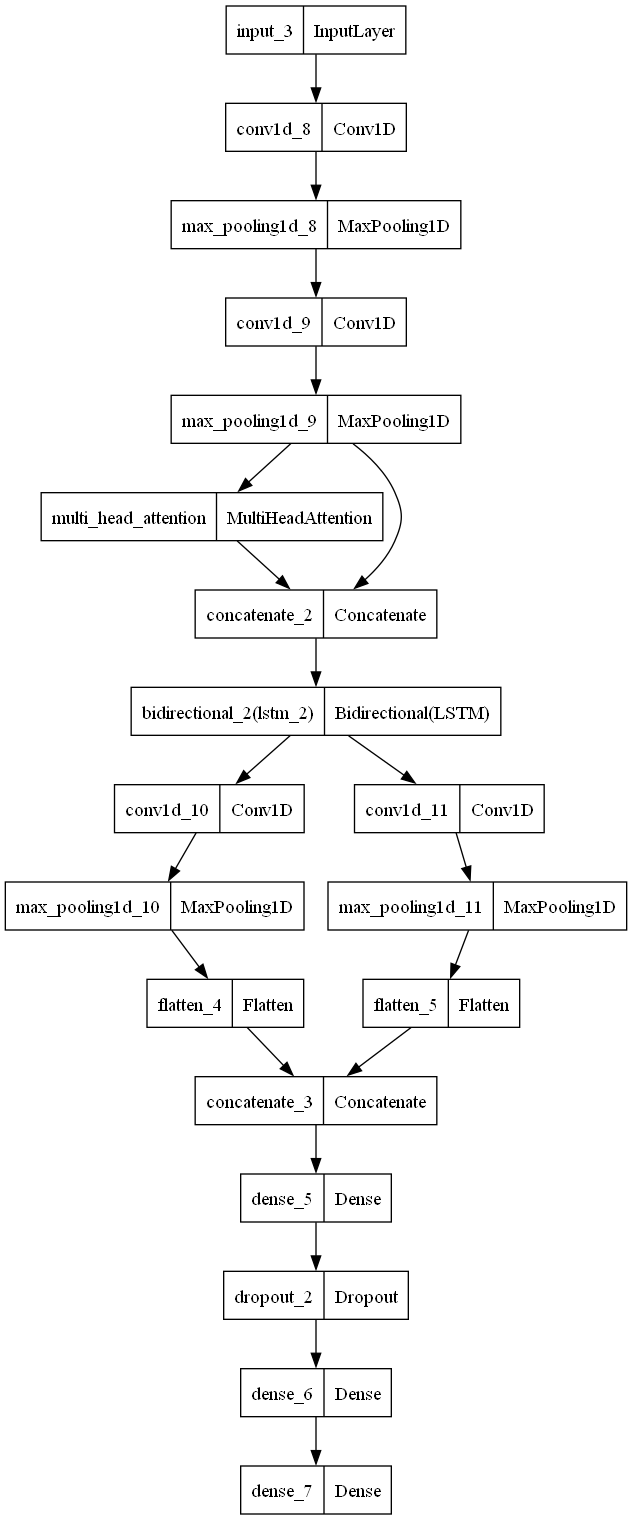

In [13]:
tf.keras.utils.plot_model(model)

In [14]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_AUC', patience=3, verbose=1, min_delta=0, mode="max")

model.fit(X_train, y_train, batch_size=128, epochs=10, validation_data=(X_val,y_val), callbacks=[early_stopping])

Epoch 1/10
134/134 [==============================] - 1615s 12s/step - loss: 0.1422 - accuracy: 0.9584 - Recall: 0.2850 - Precision: 0.7809 - AUC: 0.5077 - val_loss: 0.1168 - val_accuracy: 0.9609 - val_Recall: 0.3440 - val_Precision: 0.7854 - val_AUC: 0.5377
Epoch 2/10
134/134 [==============================] - 1979s 15s/step - loss: 0.1143 - accuracy: 0.9596 - Recall: 0.3060 - Precision: 0.7979 - AUC: 0.5653 - val_loss: 0.1085 - val_accuracy: 0.9603 - val_Recall: 0.3116 - val_Precision: 0.8095 - val_AUC: 0.5961
Epoch 3/10
134/134 [==============================] - 1785s 13s/step - loss: 0.1058 - accuracy: 0.9596 - Recall: 0.2939 - Precision: 0.8160 - AUC: 0.6080 - val_loss: 0.1007 - val_accuracy: 0.9606 - val_Recall: 0.2966 - val_Precision: 0.8518 - val_AUC: 0.6202
Epoch 4/10
134/134 [==============================] - 1421s 11s/step - loss: 0.0987 - accuracy: 0.9602 - Recall: 0.2856 - Precision: 0.8622 - AUC: 0.6440 - val_loss: 0.0980 - val_accuracy: 0.9618 - val_Recall: 0.3099 - val_